In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import ast
from mpl_toolkits import mplot3d
import math
import timeit
import os
%matplotlib widget

# Some basic setup

In [2]:
hand_scores = [1,2,3,4,5,7,8] #Ignores flush, straight flush, royal flush

redraw_combs={} #index replacement list, comb list index for ease of use
redraw_combs_rev = {}
count = 0
for i in range(6):
    test = list(itertools.combinations([0,1,2,3,4],i))
    for j,val in enumerate(test):
        redraw_combs[val] = count
        redraw_combs_rev[count] = val
        count += 1

In [3]:
score_test_dict = {1:"None",
                   2:"Pair",
                   3:"Two Pair",
                   4:"Three of a Kind",
                   5:"Straight",
                   6:"Flush",
                   7:"Fullhouse",
                   8:"Four of a Kind"}

In [4]:
card_label_dict = {1:["High Card","2nd Highest","3rd Highest","4th Highest","Lowest"],
                  2:["Pair","Pair","High Card","2nd Highest","Lowest"],
                  3:["Pair1","Pair1","Pair2","Pair2","High Card"],
                  4:["Three","Three","Three","High Card","Lowest"],
                  5:["Straight Highest","2nd Highest","3rd Highest","4th Highest","Lowest"],
                  6:["High Card","2nd Highest","3rd Highest","4th Highest","Lowest"],
                  7:["House Triple","House Triple","House Triple","House Pair","House Pair"],
                  8:["Four","Four","Four","Four","High Card"]}

## Grabbing known dataset and adding some columns

In [5]:
#Read baseline winrates dataset
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname("Hand Winrates.csv"))) #Grab relative location of this file
#__location__ = os.path.join(__location__,"1 AI Value Based") #For some reason the current subfolder is unknown to the getcwd so adding manually

df = pd.read_csv(os.path.join(__location__,"Hand Winrates.csv"))

#Add in columns for the value per card in hand, easier than using the Hand List column
hand_card_values = [[],[],[],[],[]]
for i in range(len(df)):
    aa = ast.literal_eval(df["Hand List"].iloc[i])
    for i in range(5):
        hand_card_values[i].append(aa[i])
for i in range(5):
    s = "Card "+str(i+1)
    df[s] = hand_card_values[i]
hands = pd.unique(df["Hand List"])

#Add in ranking value by mean winrate per hand
#Conveniently the data is already sorted by handlist and mean winrate
##Search doown until curr winrate > previous, then reset count 
rankings = []
rank = 1
for row in range(len(df)):
    if row > 0 and df["Winrate"].iloc[row] > df["Winrate"].iloc[row-1]:#If this winrate > previous one, we know we've jumped to the next hand
        rank = 1 #Reset rank for next check
    #Add the rank and increment
    rankings.append(rank)
    rank+=1
#Add to the dataframe
df["Ranking"] = rankings

In [6]:
uniques = pd.unique(df["Hand List"]) #Get the unique hand entries
redraw_index = []
for row in range(len(df.index)):
    redraw_index.append(redraw_combs[tuple(ast.literal_eval(df["Index Remove"][row]))]) #Convert removal list into removal index and add in
df["Redraw Index"] = redraw_index

## Providing Text Illustration of Top Redrawing Techniques Used Per Hand Type

In [7]:
for hand_score in range(1,9):
    if hand_score != 6:
        print("")
        print("Best Techniques for {0}".format(score_test_dict[hand_score]))
        print("")
    card_types = card_label_dict[hand_score]
    for redraw_index in pd.unique(df[(df["Ranking"] == 1) & (df["Hand Score"] == hand_score)]["Redraw Index"]):
        print("    Redraw Technique {0}.".format(redraw_index))
        if redraw_combs_rev[redraw_index] == ():
            print("         Keeping entire hand.")
        for index in redraw_combs_rev[redraw_index]:
            #These are the specific hand card indices selected for removal by best redrawing technique
            print("         Removing {0} from hand.".format(card_types[index]))


Best Techniques for None

    Redraw Technique 30.
         Removing 2nd Highest from hand.
         Removing 3rd Highest from hand.
         Removing 4th Highest from hand.
         Removing Lowest from hand.
    Redraw Technique 25.
         Removing 3rd Highest from hand.
         Removing 4th Highest from hand.
         Removing Lowest from hand.

Best Techniques for Pair

    Redraw Technique 25.
         Removing High Card from hand.
         Removing 2nd Highest from hand.
         Removing Lowest from hand.
    Redraw Technique 15.
         Removing 2nd Highest from hand.
         Removing Lowest from hand.

Best Techniques for Two Pair

    Redraw Technique 5.
         Removing High Card from hand.

Best Techniques for Three of a Kind

    Redraw Technique 15.
         Removing High Card from hand.
         Removing Lowest from hand.
    Redraw Technique 4.
         Removing High Card from hand.
    Redraw Technique 5.
         Removing Lowest from hand.

Best Techniques for 

# Overall plots

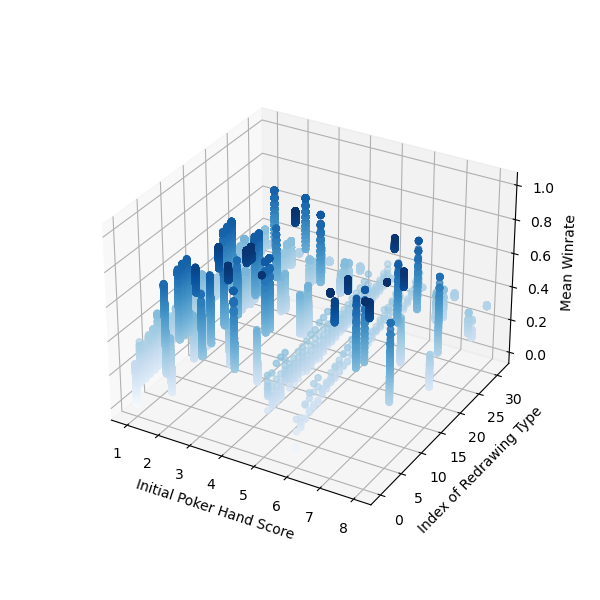

In [8]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.axes(projection='3d')
ax.scatter3D(df["Hand Score"],df["Redraw Index"],df["Winrate"], c=df["Winrate"],cmap='Blues')
ax.set_xlabel('Initial Poker Hand Score')
ax.set_ylabel('Index of Redrawing Type')
ax.set_zlabel('Mean Winrate');

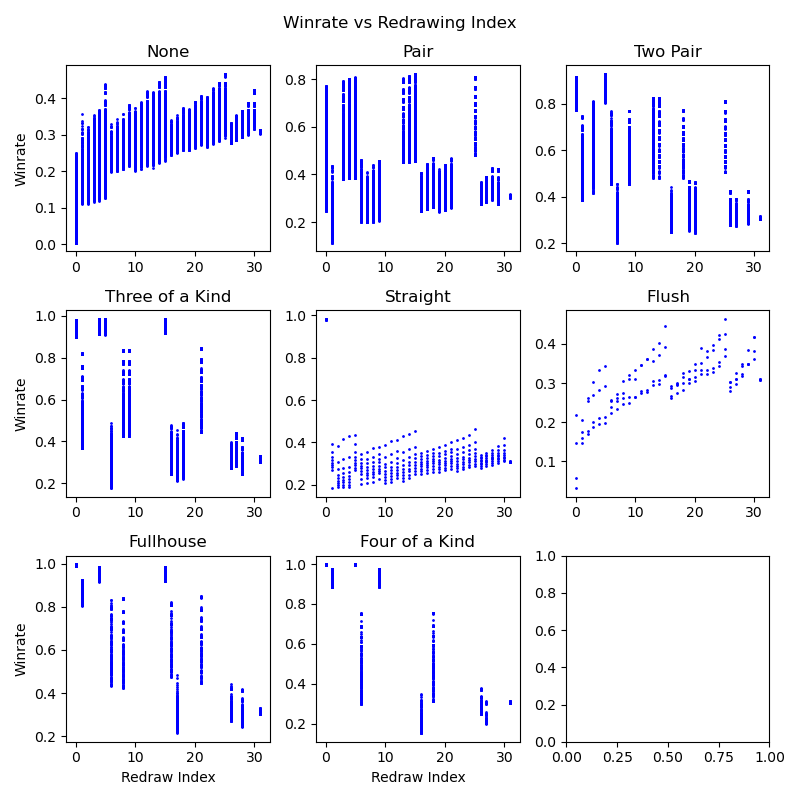

In [9]:

fig, axs = plt.subplots(3,3)
fig.set_figheight(8)
fig.set_figwidth(8)
for i in range(1,9):
    df_select = df[df["Hand Score"] == i]
    axs[math.floor((i-1)/3),(i-1)%3].plot(df_select["Redraw Index"],df_select["Winrate"],'bo',markersize=1)
    if (i-1)%3 == 0:
        axs[math.floor((i-1)/3),(i-1)%3].set_ylabel("Winrate")
    if math.floor((i-1)/3)== 2:
        axs[math.floor((i-1)/3),(i-1)%3].set_xlabel('Redraw Index')
    try:
        axs[math.floor((i-1)/3),(i-1)%3].set_title(score_test_dict[i])
    except:
        pass
fig.suptitle("Winrate vs Redrawing Index")
fig.tight_layout();

# Plotting only the choices leading to maximum winrates

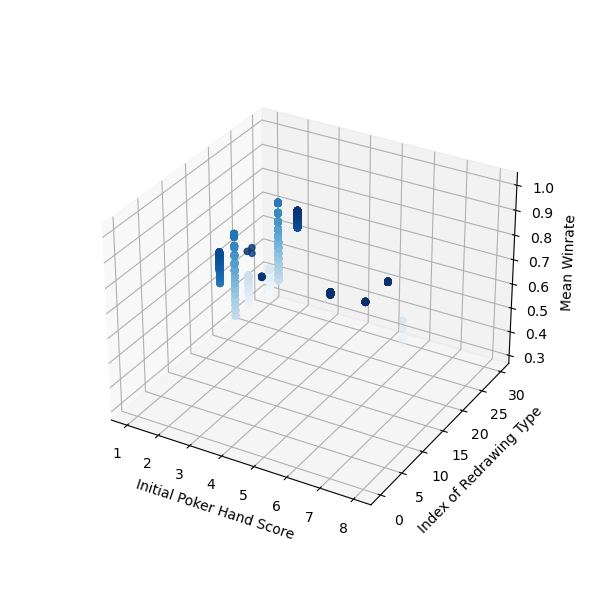

In [10]:
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.axes(projection='3d')
ax.scatter3D(df[df["Ranking"]==1]["Hand Score"],df[df["Ranking"]==1]["Redraw Index"],df[df["Ranking"]==1]["Winrate"], c=df[df["Ranking"]==1]["Winrate"],cmap='Blues')
ax.set_xlabel('Initial Poker Hand Score')
ax.set_ylabel('Index of Redrawing Type')
ax.set_zlabel('Mean Winrate');

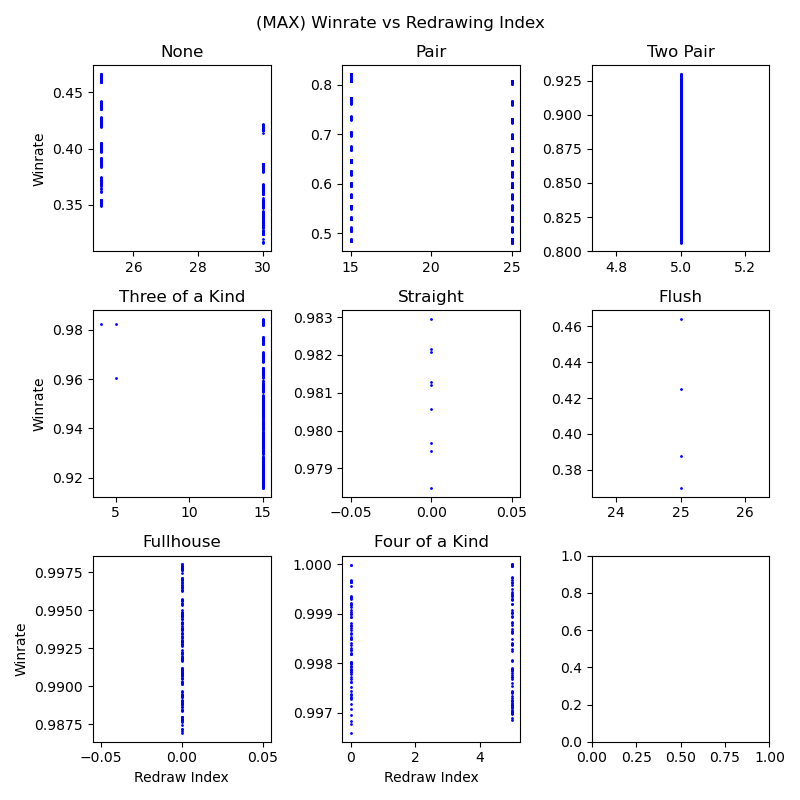

In [11]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(8)
fig.set_figwidth(8)
for i in range(1,9):
    df_select_max = df[(df["Ranking"] == 1) & (df["Hand Score"] == i)]
    axs[math.floor((i-1)/3),(i-1)%3].plot(df_select_max["Redraw Index"],df_select_max["Winrate"],'bo',markersize=1)
    if (i-1)%3 == 0:
        axs[math.floor((i-1)/3),(i-1)%3].set_ylabel("Winrate")
    if math.floor((i-1)/3)== 2:
        axs[math.floor((i-1)/3),(i-1)%3].set_xlabel('Redraw Index')
    try:
        axs[math.floor((i-1)/3),(i-1)%3].set_title(score_test_dict[i])
    except:
        pass
fig.suptitle("(MAX) Winrate vs Redrawing Index")
fig.tight_layout();

#### Why are there weird 3 of a kind outliers, why Singles and Pairs seemingly flip flopped over two redraws

In [12]:
#These appear to be outliers when considering the 2nd and 3rd winrate redraw choices
three_kind_df = df[(df["Ranking"] == 1) & (df["Hand Score"] == 4)]
three_kind_df[three_kind_df["Redraw Index"] != 15]

,Hand List,Hand Score,Index Kept,Value Kept,Index Remove,Value Remove,Winrate,Std,Card 1,Card 2,Card 3,Card 4,Card 5,Ranking,Redraw Index
26494,"[14, 14, 14, 4, 2]",4,"[0, 1, 2, 4]","[14, 14, 14, 2]",[3],[4],0.98236,0.001072,14,14,14,4,2,1,4
104218,"[14, 14, 14, 5, 4]",4,"[0, 1, 2, 3]","[14, 14, 14, 5]",[4],[4],0.98240,0.001071,14,14,14,5,4,1,5
137952,"[11, 11, 11, 7, 6]",4,"[0, 1, 2, 3]","[11, 11, 11, 7]",[4],[6],0.96028,0.001591,11,11,11,7,6,1,5


# Singles Analysis

In [14]:
#Curious about the value frequency of first few cards between main redraw types
singles_max = df[(df["Ranking"] == 1) & (df["Hand Score"] == 1)]#Highest ranking singles only
#Create new columns specifying card values in hand by order
singles25 = singles_max[singles_max["Redraw Index"] == 25]
singles30 = singles_max[singles_max["Redraw Index"] == 30]
#singles30

In [15]:
singles_max["Redraw Index"].unique() ##Keep top or top two

array([30, 25], dtype=int64)

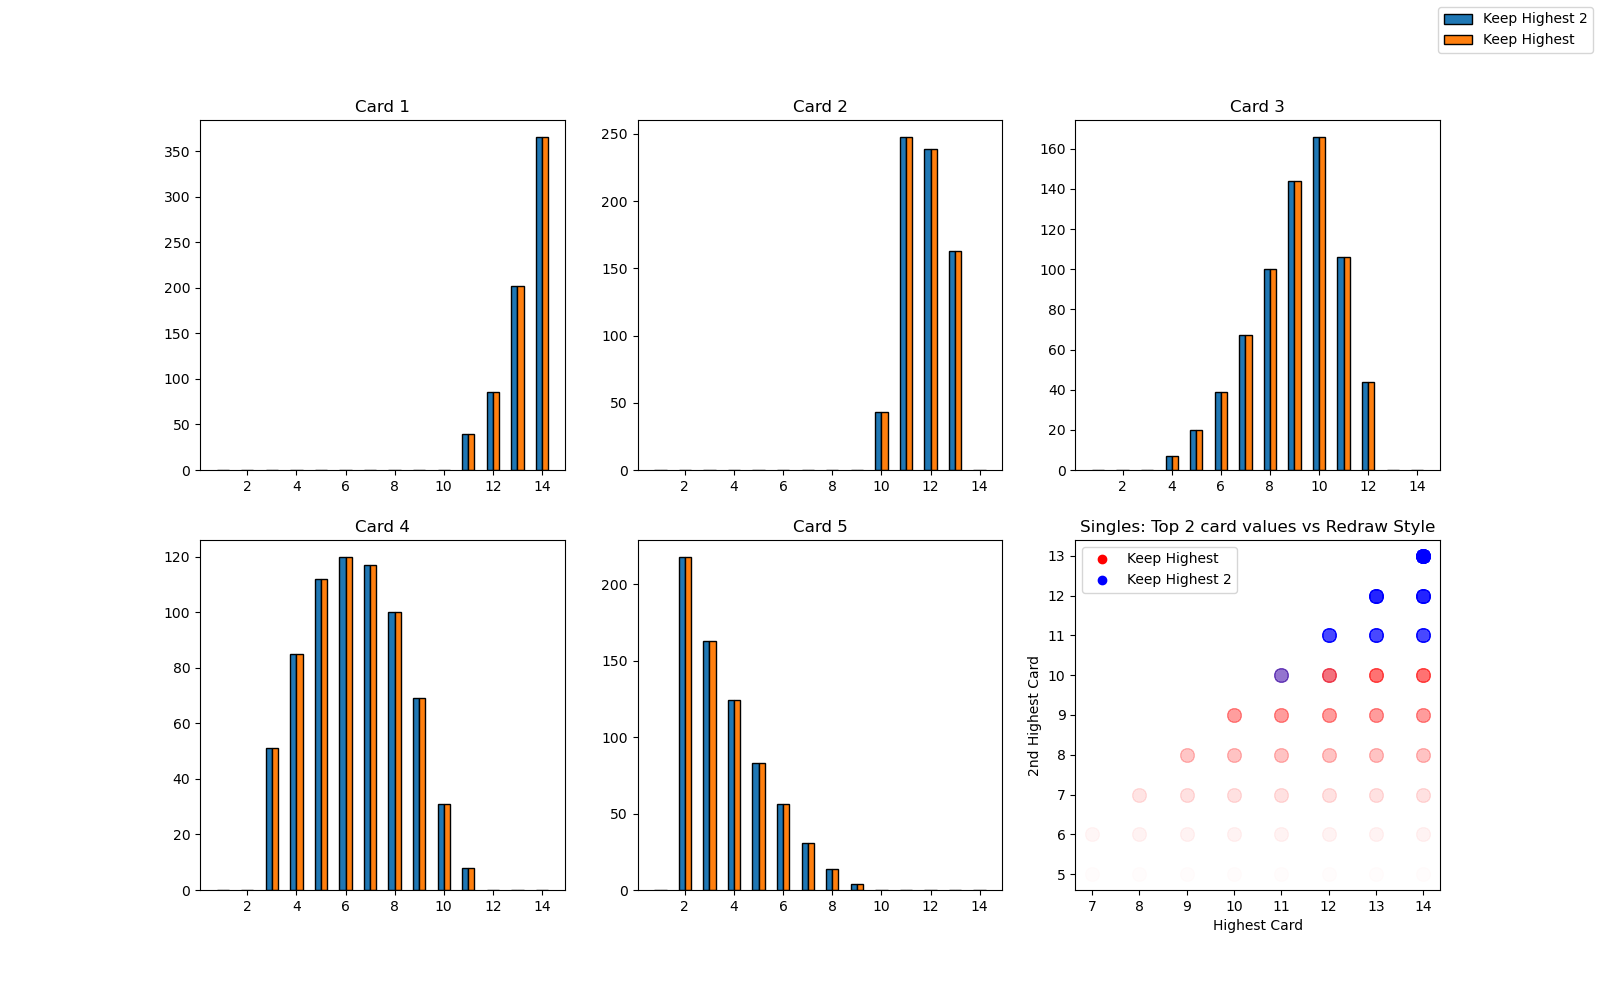

In [16]:
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(16)
for i in range(1,6):
    s = 'Card '+str(i)
    for j in range(2):
        if j == 0:
            count = singles_max[singles_max["Redraw Index"] == 25][s].value_counts()
        else:
            count = singles_max[singles_max["Redraw Index"] == 25][s].value_counts()
            
        a = count.index
        b = list(count)
        a,b = zip(*sorted(zip(a,b)))
        x = np.arange(1,15)
        y = []
        for k in range(1,15):
            if k in a:
                y.append(b[a.index(k)])
            else:
                y.append(0)
        if j == 0:
            leg = "Keep Highest 2"
        else:
            leg = "Keep Highest"
        if i != 1:
            leg = ''
        if j == 0:
            axs[math.floor((i-1)/3),(i-1)%3].bar(x-.125,y,width = .25, edgecolor = 'black',label=leg)
        else:
            axs[math.floor((i-1)/3),(i-1)%3].bar(x+0.125,y,width = .25, edgecolor = 'black',label=leg)
            pass
    axs[math.floor((i-1)/3),(i-1)%3].set_title(s)
fig.legend()

plt.scatter(singles30["Card 1"],singles30["Card 2"],s=100,alpha=0.01,color='r')
plt.scatter(singles25["Card 1"],singles25["Card 2"],s=100,alpha=0.01,color='b')
plt.plot([],[],"ro",label="Keep Highest")
plt.plot([],[],"bo",label="Keep Highest 2")
plt.title("Singles: Top 2 card values vs Redraw Style")
plt.xlabel("Highest Card")
plt.ylabel("2nd Highest Card")
plt.legend()

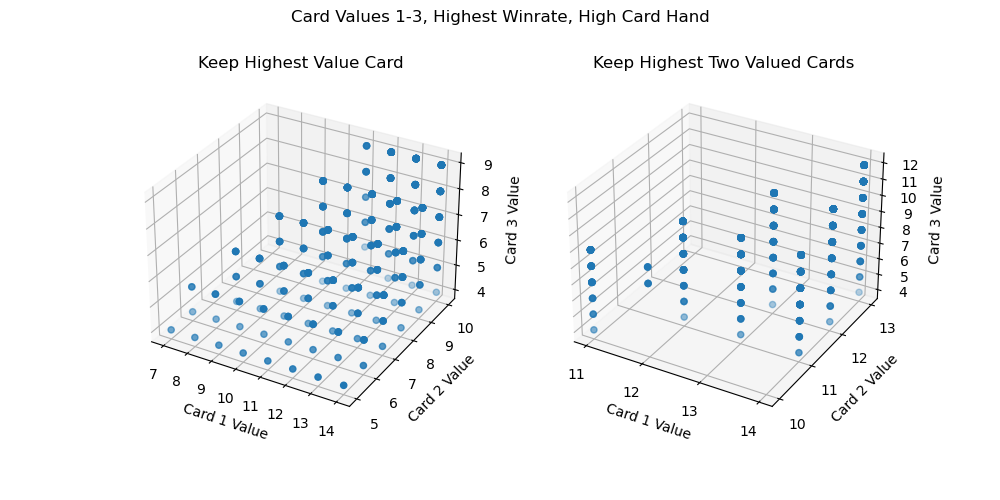

In [17]:
fig, axs = plt.subplots(1,2,subplot_kw = {'projection':'3d'})
fig.set_figheight(5)
fig.set_figwidth(10)
for ind,i in enumerate(singles_max["Redraw Index"].unique()):
    aa = singles_max[singles_max["Redraw Index"] == i]
    axs[ind].scatter3D(aa["Card 1"],aa["Card 2"],aa["Card 3"],cmap='Blues')
    axs[ind].set_xlabel('Card 1 Value') ##Highest Card
    axs[ind].set_ylabel('Card 2 Value') ##Second highest card
    axs[ind].set_zlabel('Card 3 Value') #Third highest card
    axs[ind].set_xticks(np.arange(min(aa["Card 1"]), max(aa["Card 1"])+1, 1.0))
    axs[ind].set_yticks(np.arange(min(aa["Card 2"]), max(aa["Card 2"])+1, 1.0))
    axs[ind].set_zticks(np.arange(min(aa["Card 3"]), max(aa["Card 3"])+1, 1.0))
    if singles_max["Redraw Index"].unique()[ind] == 30:
        s = "Keep Highest Value Card"
    elif singles_max["Redraw Index"].unique()[ind] == 25:
        s = "Keep Highest Two Valued Cards"
    axs[ind].set_title(s)
    fig.suptitle("Card Values 1-3, Highest Winrate, High Card Hand");

## Accounting for Standard Deviations, Only plot high confident points

In [18]:
#Highest two rankings per hand
df_1_2 = df[df["Ranking"] <= 2]

## Highs: Check if highest ranking merges into second highest => not confident enough

In [19]:
singles_1_2 = df_1_2[df_1_2["Hand Score"] == 1]
mask = []
for i in range(int(len(singles_1_2)/2)):
    winrates = (singles_1_2["Winrate"].iloc[2*i],singles_1_2["Winrate"].iloc[2*i+1])
    stds = (singles_1_2["Std"].iloc[2*i],singles_1_2["Std"].iloc[2*i+1])
    if winrates[1] + stds[1]*1.96/2.576 >= winrates[0] - stds[0]*1.96/2.576: #Changing standard deviation to 95% confidence interval rather than 99%
        #Then the 2nd best choice winrate confidence interval collides with best choice winrate confidence interval
        #We can't be certain which is really the best
        for i in range(2):
            mask.append(False) #Remove both
    else:
        mask.append(True) #Keeps top choice only
        mask.append(False) #Removes the 2nd best choice
conf_singles = singles_1_2[mask]

In [20]:
conf_singles["Redraw Index"].unique()

array([30, 25], dtype=int64)

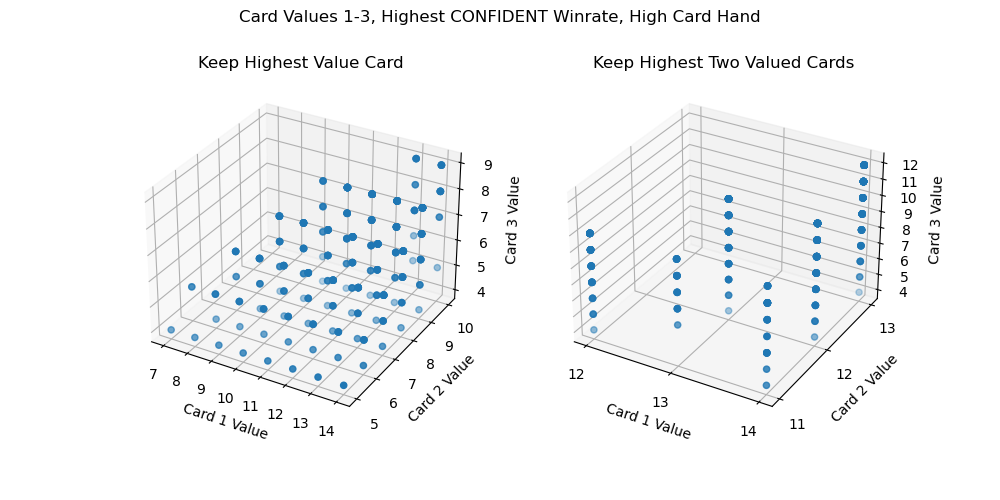

In [21]:
fig, axs = plt.subplots(1,2,subplot_kw = {'projection':'3d'})
fig.set_figheight(5)
fig.set_figwidth(10)
for ind,i in enumerate(conf_singles["Redraw Index"].unique()):
    aa = conf_singles[conf_singles["Redraw Index"] == i]
    axs[ind].scatter3D(aa["Card 1"],aa["Card 2"],aa["Card 3"],cmap='Blues')
    axs[ind].set_xlabel('Card 1 Value') ##Highest Card
    axs[ind].set_ylabel('Card 2 Value') ##Second highest card
    axs[ind].set_zlabel('Card 3 Value') #Third highest card
    axs[ind].set_xticks(np.arange(min(aa["Card 1"]), max(aa["Card 1"])+1, 1.0))
    axs[ind].set_yticks(np.arange(min(aa["Card 2"]), max(aa["Card 2"])+1, 1.0))
    axs[ind].set_zticks(np.arange(min(aa["Card 3"]), max(aa["Card 3"])+1, 1.0))
    if conf_singles["Redraw Index"].unique()[ind] == 30:
        s = "Keep Highest Value Card"
    elif conf_singles["Redraw Index"].unique()[ind] == 25:
        s = "Keep Highest Two Valued Cards"
    axs[ind].set_title(s)
    fig.suptitle("Card Values 1-3, Highest CONFIDENT Winrate, High Card Hand");

Strategy Notes:
Keep top two if highest is >=Q and second highest is >=J
Otherwise it seems taking just the highest is better or equal to top two

# Pairs Analysis

In [22]:
#Curious about the value frequency of first few cards between main redraw types
pairs_max = df[(df["Ranking"] == 1) & (df["Hand Score"] == 2)]
#Create new columns specifying card values in hand by order
hand_card_values = [[],[],[],[],[]]
for i in range(len(pairs_max)):
    aa = ast.literal_eval(pairs_max["Hand List"].iloc[i])
    for i in range(5):
        hand_card_values[i].append(aa[i])
for i in range(5):
    s = "Card "+str(i+1)
    pairs_max[s] = hand_card_values[i]

pairs25 = pairs_max[pairs_max["Redraw Index"] == 25]
pairs15 = pairs_max[pairs_max["Redraw Index"] == 15]

C:\Users\diamo\AppData\Local\Temp\ipykernel_13180\1748354962.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_max[s] = hand_card_values[i]


In [23]:
pairs15

,Hand List,Hand Score,Index Kept,Value Kept,Index Remove,Value Remove,Winrate,Std,Card 1,Card 2,Card 3,Card 4,Card 5,Ranking,Redraw Index
1998,"[2, 2, 14, 5, 3]",2,"[0, 1, 2]","[2, 2, 14]","[3, 4]","[5, 3]",0.48338,0.004071,2,2,14,5,3,1,15
2208,"[2, 2, 14, 6, 3]",2,"[0, 1, 2]","[2, 2, 14]","[3, 4]","[6, 3]",0.48385,0.004071,2,2,14,6,3,1,15
4008,"[2, 2, 14, 8, 4]",2,"[0, 1, 2]","[2, 2, 14]","[3, 4]","[8, 4]",0.48538,0.004071,2,2,14,8,4,1,15
4260,"[2, 2, 14, 10, 4]",2,"[0, 1, 2]","[2, 2, 14]","[3, 4]","[10, 4]",0.48393,0.004071,2,2,14,10,4,1,15
4350,"[2, 2, 14, 11, 4]",2,"[0, 1, 2]","[2, 2, 14]","[3, 4]","[11, 4]",0.48447,0.004071,2,2,14,11,4,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141902,"[10, 10, 14, 11, 6]",2,"[0, 1, 2]","[10, 10, 14]","[3, 4]","[11, 6]",0.67209,0.003824,10,10,14,11,6,1,15
141968,"[10, 10, 14, 12, 6]",2,"[0, 1, 2]","[10, 10, 14]","[3, 4]","[12, 6]",0.67086,0.003828,10,10,14,12,6,1,15
142010,"[10, 10, 14, 13, 6]",2,"[0, 1, 2]","[10, 10, 14]","[3, 4]","[13, 6]",0.67362,0.003820,10,10,14,13,6,1,15
142116,"[11, 11, 14, 10, 6]",2,"[0, 1, 2]","[11, 11, 14]","[3, 4]","[10, 6]",0.70163,0.003727,11,11,14,10,6,1,15


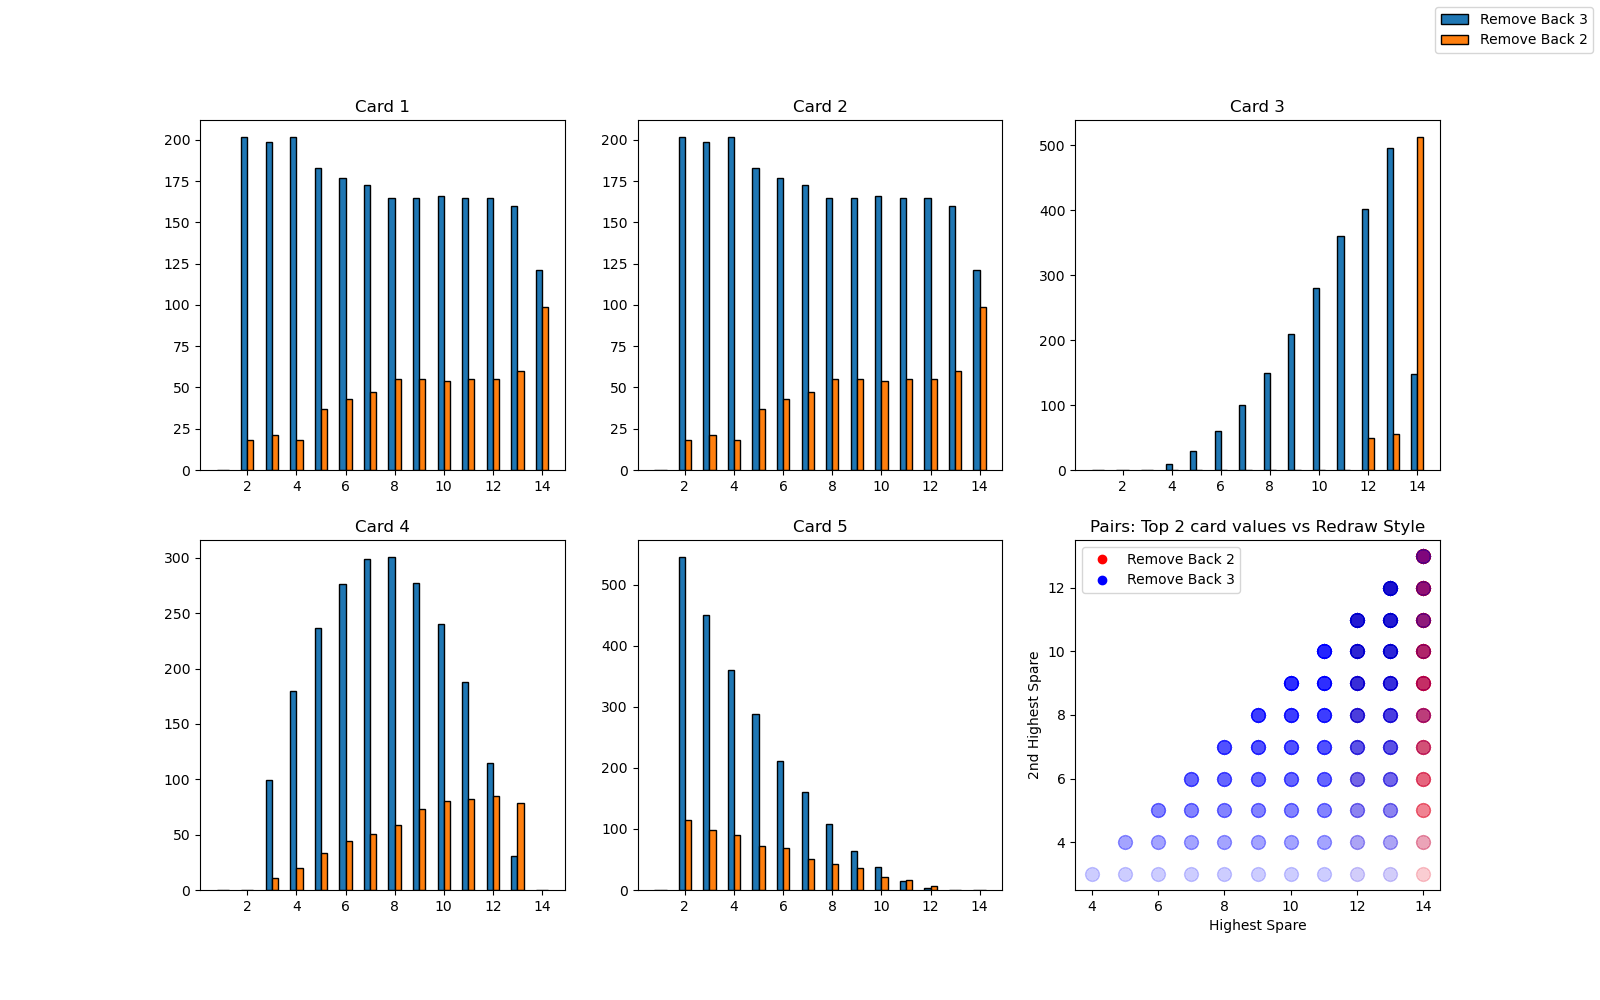

In [24]:
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(16)
for i in range(1,6):
    s = 'Card '+str(i)
    for j in range(2):
        if j == 0:
            count = pairs25[s].value_counts()
        else:
            count = pairs15[s].value_counts()
            
        a = count.index
        b = list(count)
        a,b = zip(*sorted(zip(a,b)))
        x = np.arange(1,15)
        y = []
        for k in range(1,15):
            if k in a:
                y.append(b[a.index(k)])
            else:
                y.append(0)
        if j == 0:
            leg = "Remove Back 3"
        else:
            leg = "Remove Back 2"
        if i != 1:
            leg = ''
        if j == 0:
            axs[math.floor((i-1)/3),(i-1)%3].bar(x-.125,y,width = .25, edgecolor = 'black',label=leg)
        else:
            axs[math.floor((i-1)/3),(i-1)%3].bar(x+0.125,y,width = .25, edgecolor = 'black',label=leg)
            pass
    axs[math.floor((i-1)/3),(i-1)%3].set_title(s)
fig.legend()

plt.scatter(pairs15["Card 3"],pairs15["Card 4"],s=100,alpha=0.02,color='r')
plt.scatter(pairs25["Card 3"],pairs25["Card 4"],s=100,alpha=0.02,color='b')
plt.plot([],[],"ro",label="Remove Back 2")
plt.plot([],[],"bo",label="Remove Back 3")
plt.title("Pairs: Top 2 card values vs Redraw Style")
plt.xlabel("Highest Spare")
plt.ylabel("2nd Highest Spare")
plt.legend()

# Same as before but a specific pair value

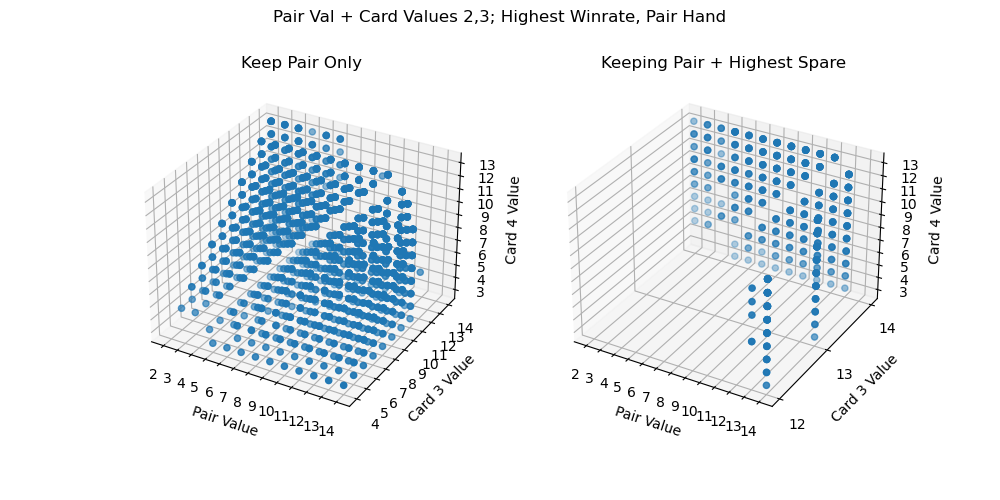

In [25]:
fig, axs = plt.subplots(1,2,subplot_kw = {'projection':'3d'})
fig.set_figheight(5)
fig.set_figwidth(10)
for ind,i in enumerate(pairs_max["Redraw Index"].unique()):
    aa = pairs_max[pairs_max["Redraw Index"] == i]
    axs[ind].scatter3D(aa["Card 2"],aa["Card 3"],aa["Card 4"],cmap='Blues')
    axs[ind].set_xlabel('Pair Value') #Highest Card
    axs[ind].set_ylabel('Card 3 Value') #Second highest card
    axs[ind].set_zlabel('Card 4 Value') #Third highest card
    axs[ind].set_xticks(np.arange(min(aa["Card 2"]), max(aa["Card 2"])+1, 1.0))
    axs[ind].set_yticks(np.arange(min(aa["Card 3"]), max(aa["Card 3"])+1, 1.0))
    axs[ind].set_zticks(np.arange(min(aa["Card 4"]), max(aa["Card 4"])+1, 1.0))
    if pairs_max["Redraw Index"].unique()[ind] == 15:
        s = "Keeping Pair + Highest Spare"
    elif pairs_max["Redraw Index"].unique()[ind] == 25:
        s = "Keep Pair Only"
    axs[ind].set_title(s)
    fig.suptitle("Pair Val + Card Values 2,3; Highest Winrate, Pair Hand");

## Plotting only highly confident points

In [26]:
df_1_2 = df[df["Ranking"] <= 2]
pairs_1_2 = df_1_2[df_1_2["Hand Score"] == 2]
mask = []
for i in range(int(len(pairs_1_2)/2)):
    winrates = (pairs_1_2["Winrate"].iloc[2*i],pairs_1_2["Winrate"].iloc[2*i+1])
    stds = (pairs_1_2["Std"].iloc[2*i],pairs_1_2["Std"].iloc[2*i+1])
    if winrates[1] + stds[1]*1.96/2.576 >= winrates[0] - stds[0]*1.96/2.576: #Changing standard deviation to 95% confidence interval rather than 99%
        #Then the 2nd best choice winrate confidence interval collides with best choice winrate confidence interval
        #We can't be certain which is really the best
        for i in range(2):
            mask.append(False) #Remove both
    else:
        mask.append(True) #Keeps top choice only
        mask.append(False) #Removes the 2nd best choice
conf_pairs = pairs_1_2[mask]
conf_pairs["Redraw Index"].unique()

array([25, 15], dtype=int64)

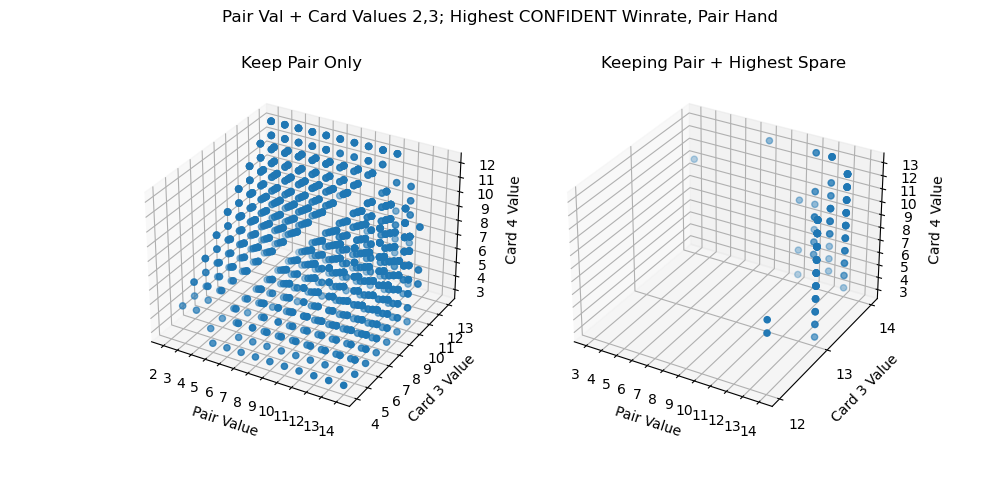

In [27]:
fig, axs = plt.subplots(1,2,subplot_kw = {'projection':'3d'})
fig.set_figheight(5)
fig.set_figwidth(10)
for ind,i in enumerate(conf_pairs["Redraw Index"].unique()):
    aa = conf_pairs[conf_pairs["Redraw Index"] == i]
    axs[ind].scatter3D(aa["Card 2"],aa["Card 3"],aa["Card 4"],cmap='Blues')
    axs[ind].set_xlabel('Pair Value') ##Highest Card
    axs[ind].set_ylabel('Card 3 Value') ##Second highest card
    axs[ind].set_zlabel('Card 4 Value') #Third highest card
    axs[ind].set_xticks(np.arange(min(aa["Card 2"]), max(aa["Card 2"])+1, 1.0))
    axs[ind].set_yticks(np.arange(min(aa["Card 3"]), max(aa["Card 3"])+1, 1.0))
    axs[ind].set_zticks(np.arange(min(aa["Card 4"]), max(aa["Card 4"])+1, 1.0))
    if conf_pairs["Redraw Index"].unique()[ind] == 15:
        s = "Keeping Pair + Highest Spare"
    elif conf_pairs["Redraw Index"].unique()[ind] == 25:
        s = "Keep Pair Only"
    axs[ind].set_title(s)
    fig.suptitle("Pair Val + Card Values 2,3; Highest CONFIDENT Winrate, Pair Hand");

Strategy Notes:
Keep Pair + High:
    Pairs Ace:
        Q + 7,8
        K + Any
    Pairs J to K:
        A + nearly any
Keep Pair only otherwise

In [28]:
pairs_1_2[(pairs_1_2['Card 1'] == 14) & (pairs_1_2['Card 2'] == 14) & (pairs_1_2['Card 3'] == 12)]

,Hand List,Hand Score,Index Kept,Value Kept,Index Remove,Value Remove,Winrate,Std,Card 1,Card 2,Card 3,Card 4,Card 5,Ranking,Redraw Index
18816,"[14, 14, 12, 3, 2]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[3, 2]",0.80751,0.003212,14,14,12,3,2,1,15
18817,"[14, 14, 12, 3, 2]",2,"[0, 1]","[14, 14]","[2, 3, 4]","[12, 3, 2]",0.80519,0.003226,14,14,12,3,2,2,25
26406,"[14, 14, 12, 4, 2]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[4, 2]",0.80799,0.003209,14,14,12,4,2,1,15
26407,"[14, 14, 12, 4, 2]",2,"[0, 1]","[14, 14]","[2, 3, 4]","[12, 4, 2]",0.80597,0.003221,14,14,12,4,2,2,25
32146,"[14, 14, 12, 5, 2]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[5, 2]",0.80987,0.003197,14,14,12,5,2,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138329,"[14, 14, 12, 7, 6]",2,"[0, 1]","[14, 14]","[2, 3, 4]","[12, 7, 6]",0.80734,0.003213,14,14,12,7,6,2,25
140358,"[14, 14, 12, 8, 6]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[8, 6]",0.80941,0.003199,14,14,12,8,6,1,15
140359,"[14, 14, 12, 8, 6]",2,"[0, 1]","[14, 14]","[2, 3, 4]","[12, 8, 6]",0.80750,0.003212,14,14,12,8,6,2,25
141658,"[14, 14, 12, 9, 6]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[9, 6]",0.80942,0.003199,14,14,12,9,6,1,15


In [29]:
conf_pairs[(conf_pairs['Card 1'] == 14) & (conf_pairs['Card 2'] == 14) & (conf_pairs['Card 3'] == 12)]

,Hand List,Hand Score,Index Kept,Value Kept,Index Remove,Value Remove,Winrate,Std,Card 1,Card 2,Card 3,Card 4,Card 5,Ranking,Redraw Index
113370,"[14, 14, 12, 8, 4]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[8, 4]",0.81035,0.003193,14,14,12,8,4,1,15
127504,"[14, 14, 12, 7, 5]",2,"[0, 1, 2]","[14, 14, 12]","[3, 4]","[7, 5]",0.80849,0.003205,14,14,12,7,5,1,15


In [37]:
df[(df["Ranking"]<=6) & (df["Hand List"]=="[13, 11, 8, 6, 2]")]

,Hand List,Hand Score,Index Kept,Value Kept,Index Remove,Value Remove,Winrate,Std,Card 1,Card 2,Card 3,Card 4,Card 5,Ranking,Redraw Index
34780,"[13, 11, 8, 6, 2]",1,"[0, 1]","[13, 11]","[2, 3, 4]","[8, 6, 2]",0.38704,0.003968,13,11,8,6,2,1,25
34781,"[13, 11, 8, 6, 2]",1,[0],[13],"[1, 2, 3, 4]","[11, 8, 6, 2]",0.38332,0.003961,13,11,8,6,2,2,30
34782,"[13, 11, 8, 6, 2]",1,"[0, 2]","[13, 8]","[1, 3, 4]","[11, 6, 2]",0.35898,0.003908,13,11,8,6,2,3,24
34783,"[13, 11, 8, 6, 2]",1,[1],[11],"[0, 2, 3, 4]","[13, 8, 6, 2]",0.35246,0.003892,13,11,8,6,2,4,29
34784,"[13, 11, 8, 6, 2]",1,"[0, 3]","[13, 6]","[1, 2, 4]","[11, 8, 2]",0.34837,0.003881,13,11,8,6,2,5,23
34785,"[13, 11, 8, 6, 2]",1,"[1, 2]","[11, 8]","[0, 3, 4]","[13, 6, 2]",0.33244,0.003837,13,11,8,6,2,6,21
